# Load JSON Data from Lakehouse

In [1]:
# Load and enrich JSON
import os
import json

json_docs = []
header_path = '/lakehouse/default/Files/book_enriched'

for file_name in os.listdir(header_path):
    file_path = os.path.join(header_path,file_name)

    # Open current file
    with open(file_path,'r') as f:
        json_content = f.read()
        json_doc = json.loads(json_content)
 
    json_docs.append(json_doc)

StatementMeta(, f3f89cc4-ed08-41a2-9641-b7fa88cd335d, 3, Finished, Available)

# Finding Semantic Similarities Between Text with TSNE

In [2]:
# Get the embeddings from the JSON docs
book_embeddings = [item['embedding'] for item in json_docs]

StatementMeta(, f3f89cc4-ed08-41a2-9641-b7fa88cd335d, 4, Finished, Available)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

StatementMeta(, f3f89cc4-ed08-41a2-9641-b7fa88cd335d, 5, Finished, Available)

In [4]:
# Calculate cosine similarity (optional, but useful for comparison)
def cosine_similarity(embedding1, embedding2):
    dot_product = np.dot(embedding1, embedding2)
    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    return dot_product / (norm1 * norm2)

StatementMeta(, f3f89cc4-ed08-41a2-9641-b7fa88cd335d, 6, Finished, Available)

In [1]:
# Compute pairwise cosine similarity between embeddings
num_embeddings = len(book_embeddings)
cosine_matrix = np.zeros((num_embeddings, num_embeddings))
for i in range(num_embeddings):
    for j in range(i + 1, num_embeddings):
        similarity = cosine_similarity(book_embeddings[i], book_embeddings[j])
        cosine_matrix[i, j] = similarity
        cosine_matrix[j, i] = similarity

# Apply t-SNE to reduce dimensionality
embedded_matrix = np.array(book_embeddings)
tsne = TSNE(n_components=2, perplexity=1, random_state=0)
embedded_points = tsne.fit_transform(embedded_matrix)

StatementMeta(, , , SessionStarting, )

StatementMeta(, f3f89cc4-ed08-41a2-9641-b7fa88cd335d, 8, Finished, Available)

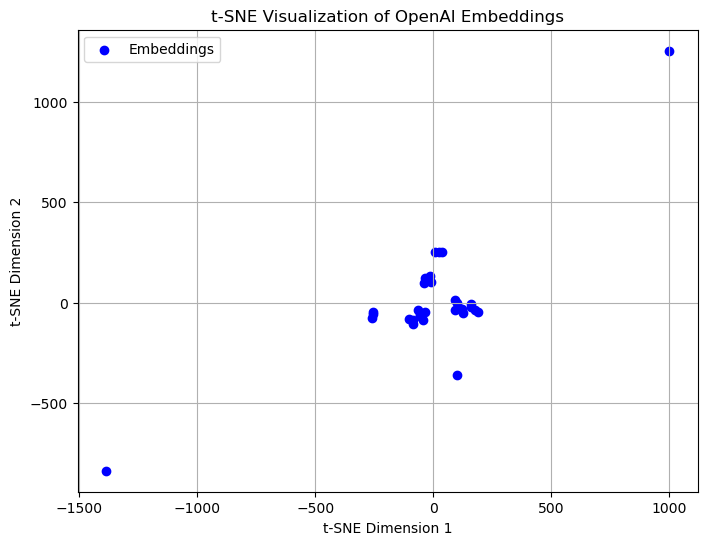

In [6]:
# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(embedded_points[:, 0], embedded_points[:, 1], c='b', marker='o', label='Embeddings')
plt.title('t-SNE Visualization of OpenAI Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.legend()
plt.grid(True)
plt.show()

# Include TSNE Dimensions with Book Data

In [9]:
books_ids = [item['book_id'] for item in json_docs]
x_axes = [float(item[0]) for item in embedded_points]
y_axes = [float(item[1]) for item in embedded_points]

StatementMeta(, f3f89cc4-ed08-41a2-9641-b7fa88cd335d, 11, Finished, Available)

In [10]:
from pyspark.sql.types import StructType, StructField, FloatType, IntegerType

# Specify schmea
table_schema = StructType([
    StructField('book_id', IntegerType(), True),
    StructField('x_axis', FloatType(), False),
    StructField('y_axis', FloatType(), False)
])

# Create the DataFrame
similarity_df = spark.createDataFrame(zip(books_ids, x_axes, y_axes), schema=table_schema)

display(similarity_df.limit(5))
similarity_df.createOrReplaceTempView('book_similarities')

StatementMeta(, f3f89cc4-ed08-41a2-9641-b7fa88cd335d, 12, Finished, Available)

SynapseWidget(Synapse.DataFrame, 8c2e68e8-4559-45b0-abcd-b5fbe38fe701)

In [11]:
# Join df back to original table using SparkSQL
joined_df = spark.sql("""
    SELECT 
        B.*,
        BS.x_axis,
        BS.y_axis
    FROM gutenberg_lakehouse.books B
    JOIN book_similarities BS ON BS.book_id = B.book_id
""")

display(joined_df.limit(5))

StatementMeta(, f3f89cc4-ed08-41a2-9641-b7fa88cd335d, 13, Finished, Available)

SynapseWidget(Synapse.DataFrame, e7501f8c-7777-4202-8a38-49acfe0cf5d1)

In [12]:
joined_df.write.format('delta').mode('overwrite').option('overwriteSchema','true').saveAsTable('books')

StatementMeta(, f3f89cc4-ed08-41a2-9641-b7fa88cd335d, 14, Finished, Available)